# Imports and Defaults

In [1]:
from datetime import date
import os
import multiprocessing
import sys

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(
    multiprocessing.cpu_count()
)

import blackjax
import jax
import jax.experimental.host_callback as hcb
import jax.numpy as jnp
import jax.scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(""))))
from src.utils.posteriors import get_model_path, get_data_path, get_init
from src.utils.models import BayesKitModel, grad_counter

In [2]:
# autoreload modules
%load_ext autoreload
%autoreload 2

sns.set_theme(style="whitegrid")
rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


# Hello World

In [3]:
observed = np.random.normal(10, 20, size=1_000)
def logdensity_fn(x):
    logpdf = stats.norm.logpdf(observed, x["loc"], x["scale"])
    return jnp.sum(logpdf)

In [4]:
num_chains= multiprocessing.cpu_count()
num_samples = 100_000

step_size = 1e-3
inverse_mass_matrix = jnp.array([1., 1.])
nuts = blackjax.nuts(logdensity_fn, step_size, inverse_mass_matrix)

initial_position = {"loc": np.ones(num_chains), "scale": np.ones(num_chains)}
initial_state = jax.vmap(nuts.init, in_axes=(0))(initial_position)

In [6]:
def inference_loop(rng_key, kernel, initial_state, num_samples):

    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

inference_loop_multiple_chains = jax.pmap(
    inference_loop, 
    in_axes=(0, None, 0, None), 
    static_broadcasted_argnums=(1, 3)
)

In [7]:
rng_key, sample_key = jax.random.split(rng_key)
sample_keys = jax.random.split(sample_key, num_chains)

pmap_states = inference_loop_multiple_chains(
    sample_keys, nuts.step, initial_state, num_samples
)

In [8]:
params = pmap_states.position
loc = params["loc"]
scale = params["scale"]
print(loc.mean(axis=0), scale.mean(axis=0))

# Using My Models

In [ ]:
posterior_name = "funnel10"
posterior_dir = "../../posteriors"

model_path = get_model_path(posterior_name, posterior_dir)
data_path = get_data_path(posterior_name, posterior_dir)

model = BayesKitModel(model_path=model_path, data_path=data_path)

In [ ]:
@jax.custom_vjp
def logdensity_fn(arg):
    fn = lambda x: model.log_density(np.array(x, dtype=np.float64))
    result_shape = jax.ShapeDtypeStruct((), jnp.float32)
    return jax.pure_callback(fn, result_shape, arg)

def call_grad(arg):
    fn = lambda x: model.log_density_gradient(
        np.array(x, dtype=np.float64)
    )[1]
    result_shape = jax.ShapeDtypeStruct(arg.shape, arg.dtype)
    return jax.pure_callback(fn, result_shape, arg)

def vjp_fwd(arg):
    return logdensity_fn(arg), arg

def vjp_bwd(residuals, y_bar):
    arg = residuals
    return (call_grad(arg) * y_bar,)

logdensity_fn.defvjp(vjp_fwd, vjp_bwd)

In [ ]:
x = jnp.array([-6., 2, 3, 4, 5, 6, 7, 8.1, 9, 10], dtype=jnp.float32)
v1 = jax.jit(logdensity_fn)(x)
v2 = jax.grad(logdensity_fn)(x)
print(v1)
print(v2)

-77758.086
[77779.26    -806.8576 -1210.2864 -1613.7152 -2017.1439 -2420.5728
 -2824.0015 -3267.7734 -3630.8591 -4034.2878]


In [ ]:
step_size = 1e-3
inverse_mass_matrix = jnp.array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
nuts = blackjax.nuts(logdensity_fn, step_size, inverse_mass_matrix)

state = nuts.init(x)

In [ ]:
samples = []
rng_key = jax.random.key(0)
step = jax.jit(nuts.step)
for i in range(10):
    nuts_key = jax.random.fold_in(rng_key, i)
    state, _ = nuts.step(nuts_key, state)
    samples.append(state.position)

# MEADS (Standard Normal, PMAP)

In [58]:
def inference_loop(rng_key, kernel, initial_state, num_samples):

    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

inference_loop_multiple_chains = jax.pmap(
    inference_loop, 
    in_axes=(0, None, 0, None), 
    static_broadcasted_argnums=(1, 3)
)

In [99]:
num_chains = multiprocessing.cpu_count()
num_warmup = 1_000
num_samples = 2_000

observed = np.random.normal(10, 20, size=1_000)
def logdensity_fn(x):
    logpdf = stats.norm.logpdf(observed, x["loc"], x["scale"])
    return jnp.sum(logpdf)

In [100]:
# warmup with MEADS
initial_position = {"loc": jnp.linspace(5, 15, num_chains), "scale": jnp.linspace(15, 25, num_chains)}
rng_key, key_warmup, key_sample = jax.random.split(rng_key, 3)

meads = blackjax.meads_adaptation(logdensity_fn, num_chains)
(state, parameters), _ = meads.run(key_warmup, initial_position, num_warmup)

In [101]:
# run Neal's non-reversible G-HMC
kernel = blackjax.ghmc(logdensity_fn, **parameters).step
init_states = jax.tree_util.tree_map(lambda x: x[:num_chains], state)
keys = jax.random.split(key_sample, num_chains)

states = inference_loop_multiple_chains(
    keys, kernel, init_states, num_samples
)

# MEADS (My Model, PMAP)

In [6]:
posterior_name = "funnel10"
posterior_dir = "../../posteriors"

model_path = get_model_path(posterior_name, posterior_dir)
data_path = get_data_path(posterior_name, posterior_dir)

model = BayesKitModel(model_path=model_path, data_path=data_path)
model.log_density_gradient = grad_counter(model.log_density_gradient)

/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/bridgestan/model.py:137: UserWarning: Loading a shared object /mnt/home/gturok/drghmc/posteriors/funnel10/funnel10_model.so that has already been loaded.
If the file has changed since the last time it was loaded, this load may not update the library!
  warnings.warn(


In [7]:
@jax.custom_vjp
def logdensity_fn(arg):
    fn = lambda x: model.log_density(np.array(x, dtype=np.float64))
    result_shape = jax.ShapeDtypeStruct((), jnp.float32)
    return jax.pure_callback(fn, result_shape, arg)

def call_grad(arg):
    fn = lambda x: model.log_density_gradient(np.array(x, dtype=np.float64))[1]
    result_shape = jax.ShapeDtypeStruct(arg.shape, arg.dtype)
    return jax.pure_callback(fn, result_shape, arg)

def vjp_fwd(arg):
    return logdensity_fn(arg), arg

def vjp_bwd(residuals, y_bar):
    arg = residuals
    return (call_grad(arg) * y_bar,)

logdensity_fn.defvjp(vjp_fwd, vjp_bwd)

In [8]:
def inference_loop(rng_key, kernel, initial_state, num_samples):

    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

inference_loop_multiple_chains = jax.pmap(
    inference_loop, 
    in_axes=(0, None, 0, None), 
    static_broadcasted_argnums=(1, 3)
)

In [11]:
num_chains = jax.device_count()
num_warmup = 1_000
num_samples = 100_000

init_position = [get_init(posterior_name, posterior_dir, chain) for chain in range(num_chains)]
init_position = jnp.array(init_position) # [num_chains, num_params]

In [12]:
# warmup with MEADS
rng_key, key_warmup, key_sample = jax.random.split(rng_key, 3)
meads = blackjax.meads_adaptation(logdensity_fn, num_chains)
(state, parameters), _ = meads.run(key_warmup, init_position, num_warmup)

In [13]:
parameters

{'step_size': Array(0.01445149, dtype=float32),
 'momentum_inverse_scale': Array([ 3.4148583,  7.7054377,  7.135631 ,  7.868718 ,  9.594046 ,
         7.6813807,  6.651348 , 11.908693 , 15.936691 ,  8.949334 ],      dtype=float32),
 'alpha': Array(0.0421586, dtype=float32),
 'delta': Array(0.0210793, dtype=float32)}

In [14]:
# run Neal's non-reversible G-HMC
kernel = blackjax.ghmc(logdensity_fn, **parameters).step
init_states = jax.tree_util.tree_map(lambda x: x[:num_chains], state)
keys = jax.random.split(key_sample, num_chains)

states = inference_loop_multiple_chains(
    keys, kernel, init_states, num_samples
)

In [15]:
params = states.position # [num_chains, num_samples, num_params]

In [16]:
scale = params[:, :, 0].flatten()
chains = jnp.repeat(jnp.arange(num_chains), num_samples)
data = pd.DataFrame({"scale": scale, "chain": chains})

/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


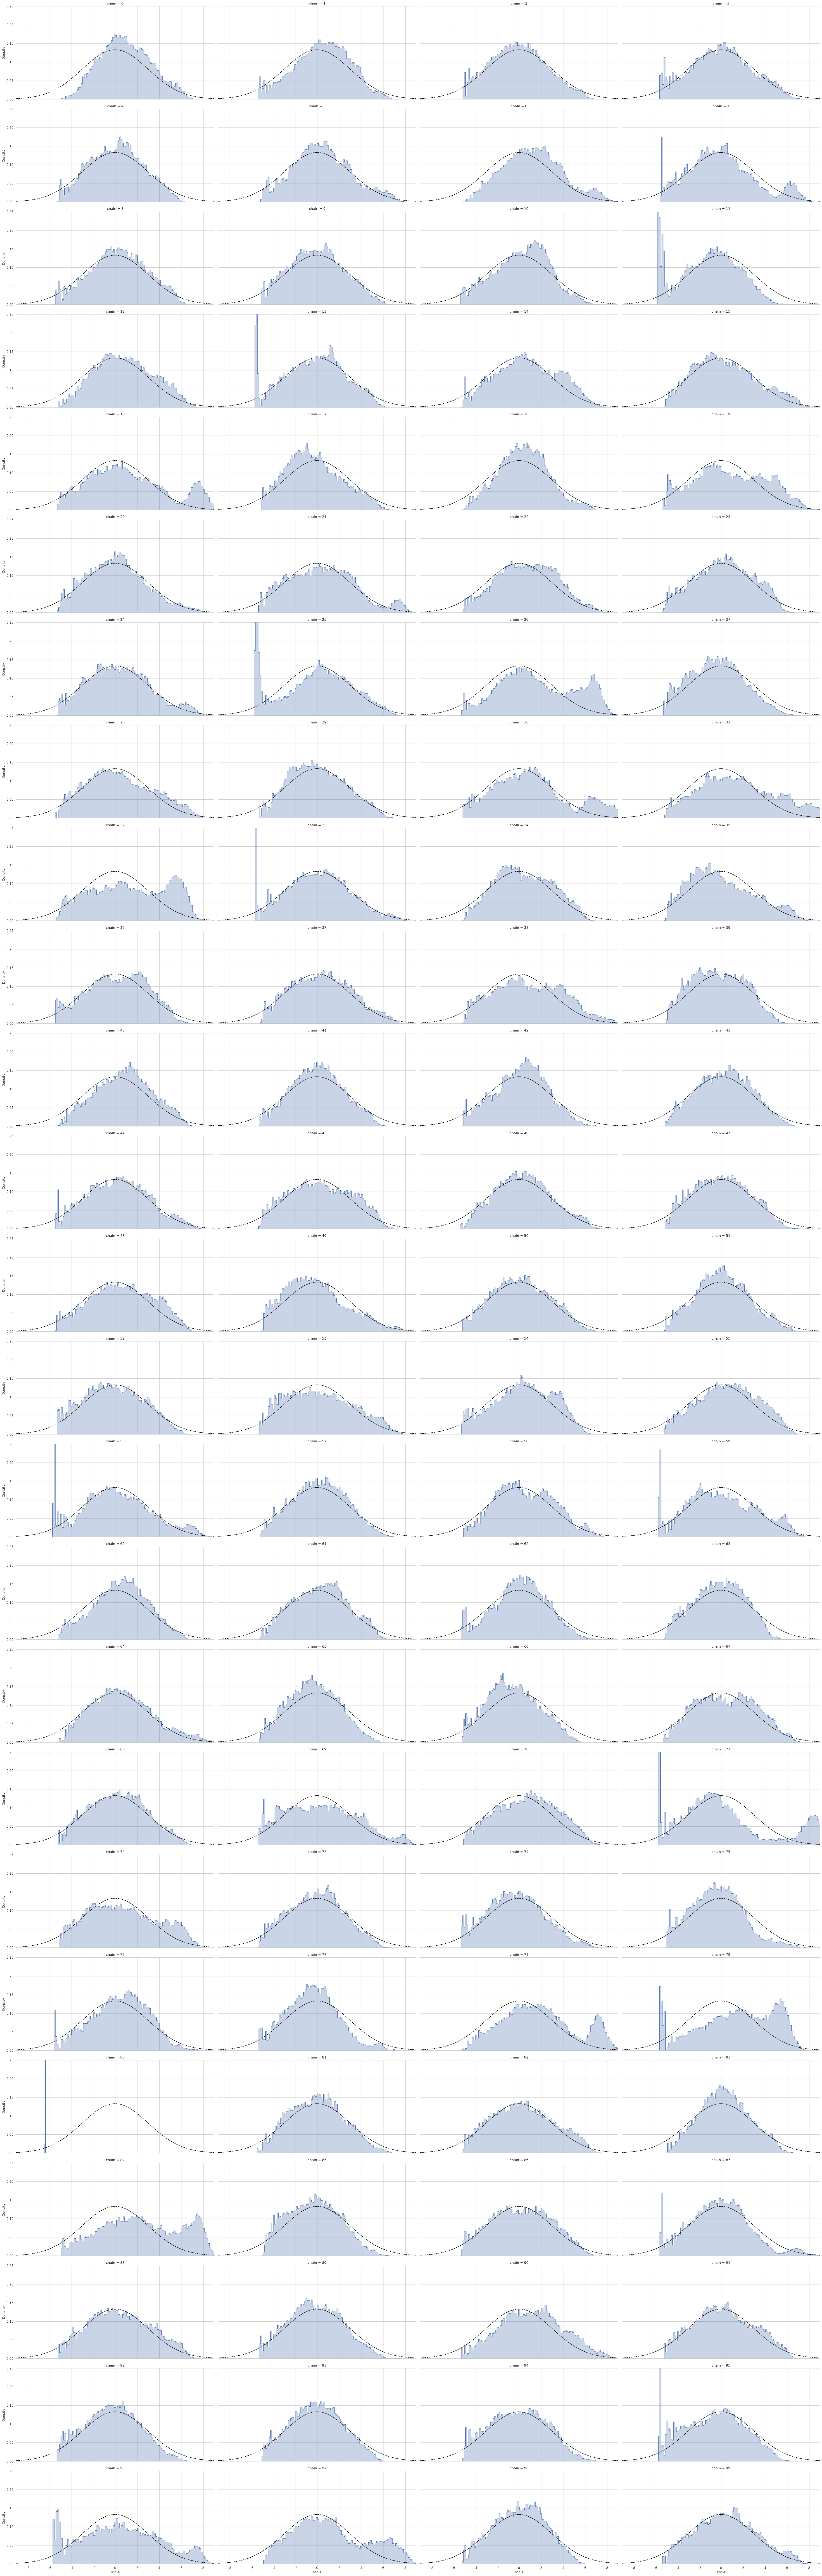

In [64]:
fig = sns.displot(
    data=data,
    x="scale",
    col="chain",
    col_wrap=4,
    stat="density",
    element="step",
    multiple="layer",
    common_norm=False,
    common_bins=False,
    fill=True,
    alpha=0.3,
    bins=100,
    legend=False,
    aspect=2,
    facet_kws={"subplot_kws" : {"xlim": (-9, 9), "ylim": (0, 0.25)}},
)

# add normal(0, 3) to plot
x = np.linspace(-9, 9, 100)
y = stats.norm.pdf(x, 0, 3)
for ax in fig.axes.flatten():
    ax.plot(x, y, color="black", linestyle="--")